In [24]:
import sys
sys.path.append('../input/callbacks')

from callbacks import *

In [25]:
# lib
import os
import gc
import random
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import Callable, List, Union

from fastprogress import master_bar, progress_bar
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers


import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.9.0+cu102'

In [26]:
data_path = '../input/commonlitreadabilityprize/'

trn_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')
sub_df = pd.read_csv(data_path + 'sample_submission.csv')

In [27]:
def rmse(preds, ys): return ((preds - ys) ** 2).mean() ** 0.5
def mse(preds, ys): return ((preds - ys) ** 2).mean()

# config

In [28]:
class CFG:
    debug: bool = False
        
    seed = SEED

    # device
    #device:torch.device = torch.device('cpu')
    device: torch.device = torch.device('cuda:0')

    # data set
    bs: int = 4
    num_workers: int = 0

    # model
    model_name = 'roberta-base'
    store_name = 'roberta-base'
    epochs: int = 5

    # gradient
    iters_to_accumulate: int = 16
    max_grad_norm: float = .5
    loss_func = None
    metric_funcs: List[Union[Callable, None]] = []

    # optimizer
    lr: int = 2e-5
    lrs: float = [lr, lr*2, lr*5, lr*10]  # 4 groups
    wd: float = 1e-2
    step_size = 4
    
    nfolds = 5
        
    # tokenizer
    max_len = 256


cfg = CFG()
cfg.metric_funcs += [rmse, mse]
cfg.loss_func = nn.MSELoss()

In [29]:
if cfg.debug:
    trn_df = trn_df.sample(frac=0.30).reset_index()
    warnings.filterwarnings('always')
    pass

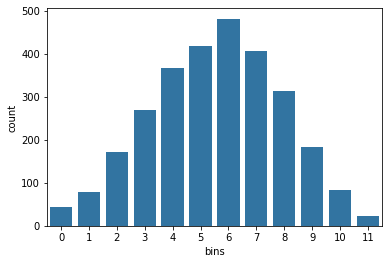

In [30]:
bins = round(1 + np.log2(len(trn_df)))
trn_df['bins'] = pd.cut(trn_df.target, bins, labels=False)

sns.countplot(trn_df['bins'], color='C0')

In [31]:
trn_df['fold'] = -1
#skf = StratifiedKFold(5, shuffle=True, random_state=cfg.seed)

skf = KFold(5, shuffle=True, random_state=cfg.seed)
for fold, (trn_idx, val_idx) in enumerate(skf.split(trn_df, y=trn_df.bins), 1):
    trn_df.loc[val_idx, 'fold'] = fold

# dataset

In [32]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls

In [33]:
class BERTDataSet(Dataset):
    def __init__(self, df, tokenizer):
        self.encodeds = tokenizer.batch_encode_plus(
            df.excerpt.tolist(),
            add_special_tokens=True,  # <s> and </s>
            max_length=cfg.max_len,          # default 512 for bert
            padding='max_length',    # padding  <pad>
            truncation=True,         # cut if length > max length
           
        )
        self.targets = df.target.values[:, None]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):

        ids = torch.tensor(self.encodeds['input_ids'][idx], dtype=torch.long)
        mask = torch.tensor(self.encodeds['attention_mask'][idx], dtype=torch.long)

        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return [ids, mask], target
    
    
if cfg.debug:
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    print(len(trn_ds))
    for x in trn_dl:
        print(x)
        break

# model

In [34]:
class AttentionHead(nn.Module):
    def __init__(self, in_size=768, h_size=512, o_size=1):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_size, h_size), 
            nn.Tanh(),  
            nn.Linear(h_size, o_size), 
            nn.Softmax(dim=1)
        )
        #self.linear = nn.Linear(in_size, o_size)
        
    def forward(self, features):
        out = self.attention(features) * features
        # (bs, lens, 768) to (bs, 768)
        out = torch.sum(out, dim=1)
        #out = self.linear(out)
        return out
    
    
class CLPRModel(nn.Module):
    def __init__(self, model_name):
        super(CLPRModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.layer_norm_eps = 1e-7
        self.config.hidden_dropout_prob = 0.0
        self.transformer = AutoModel.from_pretrained(model_name, self.config)
        
        self.hidden_size = self.config.hidden_size
        self.attention = AttentionHead(in_size=self.hidden_size)
        self.head = nn.Linear(self.hidden_size, 1)
        
    #def forward(self, input_id, attention_mask):
    def forward(self, x):
        #out = self.transformer(input_id, attention_mask)['last_hidden_state']
        out = self.transformer(*x)['last_hidden_state']
        out = self.attention(out)
        out = self.head(out)
        return out
    
if cfg.debug:
    model = CLPRModel(cfg.model_name)
    preds = model(x[0])
    print(preds.shape)

# optimizer

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


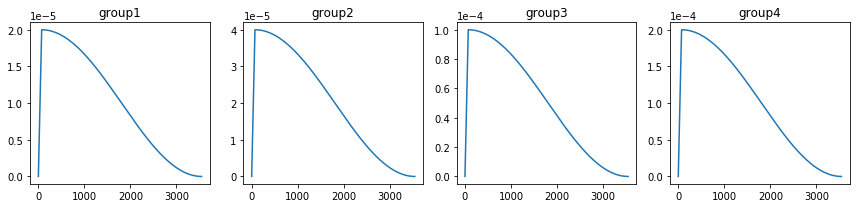

In [35]:
def create_optimizer(model, cfg):
    named_parameters = list(model.named_parameters())

    backbone_parameters = named_parameters[:199]
    head_parameters = named_parameters[199:]

    head_group = [params for (name, params) in head_parameters]

    parameters = []
    parameters.append({"params": head_group,
                       "weight_decay": 0.,
                       "lr": cfg.lrs[3]})

    for layer_num, (name, params) in enumerate(backbone_parameters):
        weight_decay = 0.0 if 'LayerNorm' in name or 'bias' in name else cfg.wd

        lr = cfg.lrs[0]

        if layer_num >= 69:
            lr = cfg.lrs[1]

        if layer_num >= 133:
            lr = cfg.lrs[2]

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)


def get_scheduler(optimizer, cfg):
    num_training_steps = len(trn_dl) * cfg.epochs
    num_warmup_steps = int(len(trn_dl) * 0.1)
    return transformers.get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps,
        num_training_steps
    )

if 1:
    # create dataloader
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    # create model
    model = CLPRModel('roberta-base')
    
    # create scheduler
    optimizer = create_optimizer(model, cfg)
    scheduler = get_scheduler(optimizer, cfg)
    
    # get lr
    lrs = []
    for epoch in range(cfg.epochs):
        for _ in trn_dl:
            lrs.append(scheduler.get_last_lr())
            optimizer.step()
            scheduler.step()
    lrs = sorted(set([*zip(*lrs)]))
    
    # plot
    plt.figure(figsize=(12, 3))
    for i, lr in enumerate(lrs, 1):
        plt.subplot(1, 4, i)
        plt.title(f'group{i}')
        plt.plot(lr)
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

In [37]:
model.transformer.save_pretrained(cfg.model_name)

# Learner

In [14]:
class Learner:
    def __init__(self, cfg, model, dls, cbs=[]):
        self.cfg = cfg
        set_cfg_attr(self, cfg)

        # model
        self.model = model.to(self.device)
        self.dls = dls
        self.optimizer = create_optimizer(self.model, self.cfg)
        self.scaler = torch.cuda.amp.GradScaler()

        # callbacks
        self.cbs = cbs
        for cb in self.cbs: cb.learner = self
        
        # init 
        self.glob_iters = 0
        self.nums_of_backward = 0 # trick for gradient accumulate
        self.mb = range(1, self.epochs + 1)
        
    def one_batch(self):
        self('before_batch')
        xb, self.yb = to_device(self.batch, self.device)
        self.batch_size = len(xb)

        # forward
        with torch.set_grad_enabled(self.train):
            with torch.cuda.amp.autocast():
                self.preds = self.model(xb)
                self.loss = self.loss_func(self.preds, self.yb)
                self.loss_item = self.loss.item()

        # backward
        if self.train:
            self.loss = self.loss / self.iters_to_accumulate
            #self.loss.backward()
            self.scaler.scale(self.loss).backward()
            self.nums_of_backward += 1
            
            if self.nums_of_backward % self.iters_to_accumulate == 0:
                self.glob_iters += 1
                
                # clip grads
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                        self.cfg.max_grad_norm)
                
                # step
                #self.optimizer.step()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
                
        self('after_batch')

    def one_epoch(self, train: bool):
        self.train = train
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        
        self.pb = self.dl
        self('before_epoch')
        for self.num, self.batch in enumerate(self.pb):
            self.one_batch()
        self('after_epoch')

    def fit_single(self):
        self('before_fit')
        for self.epoch in self.mb:
            self.one_epoch(True)
            self.one_epoch(False)
        self('after_fit')

    def save(self, path):
        path += '.pth'
        self.model.eval()
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'scaler': self.scaler.state_dict(),
                'epoch': self.epoch,
                'history': self.history,
            },
            path)

    def load(self, path, model_only=False):
        path += '.pth'
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        torch.cuda.empty_cache()
        if not model_only:
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            self.scaler.load_state_dict(checkpoint['scaler'])
            self.epoch = checkpoint['epoch']
            self.history = checkpoint['history']

    def __call__(self, name):
        for cb in self.cbs:
            getattr(cb, name, noop)()

In [15]:
class GetOOF(Callback):
    def before_fit(self):
        self.learner.oof = dict(preds=[], ys=[])
    
    def after_batch(self):
        if not self.train:
            self.oof['preds'].append(to_numpy(self.preds))
            self.oof['ys'].append(to_numpy(self.yb))

    def after_fit(self):
        self.learner.oof['preds'] = np.concatenate(self.oof['preds'])
        self.learner.oof['ys'] = np.concatenate(self.oof['ys'])

In [16]:
logger_name = datetime.today().strftime("%Y-%m-%d_%H_%M_%S")
logger = get_logger(logger_name, verbose=False)
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

In [17]:
cv_score = []
preds_oof, ys_oof = [], []

for fold in range(1, cfg.nfolds + 1):
    cfg.store_name = f'{cfg.model_name}_fold_{fold}'
    print(f'Fold: {fold}')
    logger.info(f'\nFold: {fold}\n')
    
    trn_ds = BERTDataSet(trn_df.query(f'fold != {fold}'), tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)

    val_ds = BERTDataSet(trn_df.query(f'fold == {fold}'), tokenizer)
    val_dl = DataLoader(val_ds,
                        batch_size=cfg.bs,
                        shuffle=False,
                        num_workers=cfg.num_workers,
                        pin_memory=True)


    dls = DataLoaders(trn_dl, val_dl)


    model = CLPRModel(cfg.model_name)

    cfg.backbone_config = model.config
    
    cbs = [
        Timer(), 
        Recorder(), 
        ProgressBar(),
        Scheduler(get_scheduler), 
        ModelCheckPoint(store_name=cfg.store_name, skip_start=2),
        GetOOF(),
        GetLogger(logger),
    ]
    learner = Learner(cfg, model, dls, cbs)
    learner.fit_single()
    torch.cuda.empty_cache()
    gc.collect()
    
    preds, ys = learner.oof_preds, learner.oof_ys
    metrics = {m.__name__:m(preds, ys) for m in cfg.metric_funcs}
    cv_score.append(metrics)
    
    print(f'Fold: {fold}, CV: ')
    logger.info(f'\nFold: {fold}, CV: ')
    for func_name in metrics:
        print(f'\t{func_name}: {metrics[func_name]}')
        logger.info(f'\t{func_name}: {metrics[func_name]}')
    
    preds_oof.append(preds)
    ys_oof.append(ys)

preds_oof = np.concatenate(preds_oof)
ys_oof = np.concatenate(ys_oof)
oof_score = ((preds_oof - ys_oof) ** 2).mean() ** 0.5
print(f'oof_score: {oof_score}')
logger.info(f'oof_score: {oof_score}')

Fold: 1


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch,train loss,val loss,train rmse,val rmse,train mse,val mse,time
1,0.742525,0.356206,0.789083,0.561744,0.742525,0.356206,1:40
2,0.289324,0.328156,0.502549,0.541567,0.289324,0.328156,1:45
3,0.222578,0.377371,0.441395,0.585506,0.222578,0.377371,1:46
4,0.158610,0.429370,0.374051,0.626119,0.158610,0.429370,1:46
5,0.127975,0.373152,0.335162,0.582990,0.127975,0.373152,1:47


Autoload the best model
Fold: 1, CV: 
	rmse: 0.6108992659758733
	mse: 0.37319791316986084
Fold: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch,train loss,val loss,train rmse,val rmse,train mse,val mse,time


KeyboardInterrupt: 

In [ ]:
preds_oof = np.concatenate(preds_oof)
ys_oof = np.concatenate(ys_oof)

In [ ]:
((preds_oof - ys_oof) ** 2).mean() ** 0.5

In [ ]:
with open(f'{logger_name}.log') as f:
    file = f.read()
print(file)

In [ ]:
torch.cuda.empty_cache()

##

In [ ]:
assert 0

## 

In [ ]:
def evaluate(self, dl):
    model.eval()
    
    running_loss = AverageMeter()
    running_metrics = [AverageMeter() for _ in range(len(self.metric_funcs))]
    
    for batch in dl:
        xb, yb = to_device(batch, self.device)
        batch_size = len(xb)
        

        with torch.no_grad():
            preds = self.model(xb)
            loss = self.loss_func(preds, yb)
            loss = loss.item()
            running_loss.update(loss, batch_size)
            
            for running_metric, metric_func in zip(running_metrics, self.metric_funcs):
                metric = metric_func(preds, yb)
                metric = to_numpy(metric)
                running_metric.update(metric, batch_size)
            
    print(running_loss.avg(), [m.avg() for m in running_metrics])

In [ ]:
preds, ys = np.concatenate(preds).ravel(), np.concatenate(ys).ravel()
rmse(preds, ys)

In [ ]:
preds.shape

In [ ]:
learner.load('roberta-base_fold_1', model_only=True)

In [ ]:
fold = 1
val_ds = BERTDataSet(trn_df.query(f'fold == {fold}'), tokenizer)
val_dl = DataLoader(val_ds,
                    batch_size=cfg.bs,
                    shuffle=False,
                    num_workers=cfg.num_workers,
                    pin_memory=True)

In [ ]:
learner.dls.valid = val_dl

In [ ]:
preds, ys = [], []
m = AverageMeter()
mm = []

for batch in val_dl:
    xb, yb = to_device(batch, cfg.device)
    batch_size = len(yb)
    
    with torch.no_grad():
        predb = learner.model(xb)
        
        metric = mse(predb, yb)
        mm.append(to_numpy(metric))
        m.update(to_numpy(metric), batch_size)
        preds.append(to_numpy(predb))
        ys.append(to_numpy(yb))
        
preds = np.concatenate(preds).ravel()
ys = np.concatenate(ys).ravel()
m.avg()

In [ ]:
evaluate(learner, dls.valid)

In [ ]:
def get_predict(mode='train'):
    dl = dls.train if mode == 'train' else dls.valid
    
    feats, ys = [], []
    for batch in dl:
        xb, yb = to_device(batch, cfg.device)
        with torch.no_grad():
            out = model.transformer(*xb)['last_hidden_state']
            out = model.attention(out)
            #out = model(xb)
            out = to_numpy(out)
            feats.append(out)
            ys.append(to_numpy(yb))
    feats = np.concatenate(feats) 
    ys = np.concatenate(ys) 
    return feats, ys

In [ ]:
model.eval()


trn_feats, trn_ys = get_predict(mode='train')
val_feats, val_ys = get_predict(mode='valid')
trn_feats.shape

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from lightgbm import LGBMReg ressor
from catboost import CatBoostRegressor

In [ ]:
r = Ridge().fit(trn_feats, trn_ys)

In [ ]:
rmse(r.predict(trn_feats), trn_ys), rmse(r.predict(val_feats), val_ys)

In [ ]:
np.mean(mm)

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse_score(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true,y_pred))